In [1]:
import sys
sys.path.append('..')

In [2]:
import torch
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.nn.functional as F

In [3]:
ligands = ["TNF", "R84", "PIC", "P3K", "FLA", "CpG", "FSL", "LPS", "UST"]
polarization = ["", "ib", "ig", "i0", "i3", "i4"]
replicas, size = 2, 1288 # replicated

In [4]:
from core.getdata import *
from core.dataset import *

<h3>Example of GetData</h3>

In [5]:
TNFib1 = GetData(ligands[0], polarization[1], replicas, size)
TNFib1.X.shape

(1288, 98)

<h3>Example of Dataset</h3>

In [6]:
data = Dataset(ligands, polarization, replicas, size)

In [7]:
%%time
for _ in data:
    pass

Wall time: 41.5 ms


In [8]:
data.data.shape

(69552, 98, 1)

In [9]:
print(type(data.data), type(data.labels))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [10]:
print(data.labels, data.labels.shape) #labels are multi-hot encoded

[0 0 0 ... 8 8 8] (69552,)


<h3>Initializing Dataloaders</h3>

In [11]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

In [12]:
X_len, test_len = int(len(data.data) * 0.9), int(len(data.data) * 0.1)
train_len, val_len = int(X_len * 0.9), int(X_len * 0.1)
print(X_len, test_len, train_len, val_len) #lengths
print(X_len + test_len, len(data.data))

62596 6955 56336 6259
69551 69552


In [13]:
training_data = data.data.reshape(data.data.shape[0], data.data.shape[1], 1) #adds extra dimension

In [14]:
data.data[1000].shape
len(data)

69552

In [15]:
dataset_X, dataset_val = torch.utils.data.random_split(data, [X_len, test_len + 1]) # need separate data and labels for LSTM?

In [16]:
dataloader_train = torch.utils.data.DataLoader(dataset_X, batch_size=64, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=64, shuffle=True)

In [17]:
print(len(dataloader_train), len(dataloader_val), len(dataloader_train) + len(dataloader_val))
###
#data[0:10]

979 109 1088


<h3>Model Training</h3>

In [18]:
from core.network import *
from core.trainer import *

In [19]:
torch.cuda.is_available()

True

In [20]:
#model parameters
input_size = 1
hidden_sizes = 98
output_size = 9

#training parameters
n_epochs = 80
batch_size = 64
learning_rate = 1e-3

In [21]:
model = LSTM(input_size, hidden_sizes, output_size, num_layers=3, device="cuda:0")
model.train()

LSTM(
  (lstm): LSTM(1, 98, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=98, out_features=9, bias=True)
)

In [22]:
trainer = LSTMTrainer(model=model, device="cuda:0")

In [23]:
trainer.train(dataloader_train, dataloader_val, batch_size=batch_size, n_epochs=n_epochs)

  1%|█                                                                                  | 1/80 [00:16<21:28, 16.31s/it]

Epoch 001: | Training Loss: 2.1096911048012443 | Validation Loss: 2.111623607644247


  2%|██                                                                                 | 2/80 [00:30<19:30, 15.00s/it]

Epoch 002: | Training Loss: 2.1955153228557145 | Validation Loss: 2.198388786490904


  4%|███                                                                                | 3/80 [00:44<18:51, 14.69s/it]

Epoch 003: | Training Loss: 2.173398382938919 | Validation Loss: 2.0996900315678446


  5%|████▏                                                                              | 4/80 [00:59<18:38, 14.72s/it]

Epoch 004: | Training Loss: 2.0557265906338795 | Validation Loss: 1.9906917613580686


  6%|█████▏                                                                             | 5/80 [01:13<18:12, 14.57s/it]

Epoch 005: | Training Loss: 1.8855379851529255 | Validation Loss: 1.7635230329058587


  8%|██████▏                                                                            | 6/80 [01:28<17:52, 14.49s/it]

Epoch 006: | Training Loss: 1.7058745475297563 | Validation Loss: 1.6783990192850795


  9%|███████▎                                                                           | 7/80 [01:42<17:29, 14.38s/it]

Epoch 007: | Training Loss: 1.631793905936174 | Validation Loss: 1.5993205133928072


 10%|████████▎                                                                          | 8/80 [01:56<17:13, 14.35s/it]

Epoch 008: | Training Loss: 1.5668236967004965 | Validation Loss: 1.5396640771025911


 11%|█████████▎                                                                         | 9/80 [02:10<16:56, 14.32s/it]

Epoch 009: | Training Loss: 1.5039736703418736 | Validation Loss: 1.4714594926309148


 12%|██████████▎                                                                       | 10/80 [02:25<16:45, 14.37s/it]

Epoch 010: | Training Loss: 1.448209410181328 | Validation Loss: 1.4491840447854558


 14%|███████████▎                                                                      | 11/80 [02:39<16:33, 14.39s/it]

Epoch 011: | Training Loss: 1.3962030018070015 | Validation Loss: 1.3731178056209459


 15%|████████████▎                                                                     | 12/80 [02:54<16:17, 14.37s/it]

Epoch 012: | Training Loss: 1.3462854138555518 | Validation Loss: 1.325589714793984


 16%|█████████████▎                                                                    | 13/80 [03:08<16:06, 14.42s/it]

Epoch 013: | Training Loss: 1.3032209991921686 | Validation Loss: 1.2951900335626865


 18%|██████████████▎                                                                   | 14/80 [03:23<15:54, 14.46s/it]

Epoch 014: | Training Loss: 1.2681782428285562 | Validation Loss: 1.262926195739606


 19%|███████████████▍                                                                  | 15/80 [03:37<15:36, 14.41s/it]

Epoch 015: | Training Loss: 1.2262710183097831 | Validation Loss: 1.2426010474152522


 20%|████████████████▍                                                                 | 16/80 [03:51<15:23, 14.43s/it]

Epoch 016: | Training Loss: 1.1982989498129661 | Validation Loss: 1.2156787388915316


 21%|█████████████████▍                                                                | 17/80 [04:06<15:09, 14.44s/it]

Epoch 017: | Training Loss: 1.1655502830145916 | Validation Loss: 1.2216582577162927


 22%|██████████████████▍                                                               | 18/80 [04:20<14:53, 14.41s/it]

Epoch 018: | Training Loss: 1.1339706664065905 | Validation Loss: 1.16934558612491


 24%|███████████████████▍                                                              | 19/80 [04:35<14:39, 14.41s/it]

Epoch 019: | Training Loss: 1.1109222999266877 | Validation Loss: 1.1732120541257596


 25%|████████████████████▌                                                             | 20/80 [04:49<14:24, 14.41s/it]

Epoch 020: | Training Loss: 1.0746796790499 | Validation Loss: 1.1338663051981446


 26%|█████████████████████▌                                                            | 21/80 [05:03<14:03, 14.30s/it]

Epoch 021: | Training Loss: 1.040780669395965 | Validation Loss: 1.1104785734360372


 28%|██████████████████████▌                                                           | 22/80 [05:18<13:53, 14.36s/it]

Epoch 022: | Training Loss: 1.0056797625826133 | Validation Loss: 1.1261125644412608


 29%|███████████████████████▌                                                          | 23/80 [05:32<13:35, 14.32s/it]

Epoch 023: | Training Loss: 0.9840713296774337 | Validation Loss: 1.0807918326570354


 30%|████████████████████████▌                                                         | 24/80 [05:47<13:29, 14.45s/it]

Epoch 024: | Training Loss: 0.9536903043933007 | Validation Loss: 1.0543127278669164


 31%|█████████████████████████▋                                                        | 25/80 [06:01<13:11, 14.38s/it]

Epoch 025: | Training Loss: 0.9231984367835753 | Validation Loss: 1.0161516420338133


 32%|██████████████████████████▋                                                       | 26/80 [06:15<12:56, 14.39s/it]

Epoch 026: | Training Loss: 0.887049980986715 | Validation Loss: 0.9924949161503294


 34%|███████████████████████████▋                                                      | 27/80 [06:29<12:41, 14.36s/it]

Epoch 027: | Training Loss: 0.8458519767326768 | Validation Loss: 0.99870631180772


 35%|████████████████████████████▋                                                     | 28/80 [06:44<12:31, 14.45s/it]

Epoch 028: | Training Loss: 0.8275424372005268 | Validation Loss: 0.985096515865501


 36%|█████████████████████████████▋                                                    | 29/80 [06:59<12:26, 14.63s/it]

Epoch 029: | Training Loss: 0.7898359051520296 | Validation Loss: 0.9418377920028267


 38%|██████████████████████████████▊                                                   | 30/80 [07:14<12:09, 14.60s/it]

Epoch 030: | Training Loss: 0.7551513329772346 | Validation Loss: 0.941327884109742


 39%|███████████████████████████████▊                                                  | 31/80 [07:28<11:53, 14.56s/it]

Epoch 031: | Training Loss: 0.7301598835405461 | Validation Loss: 0.9201685567514613


 40%|████████████████████████████████▊                                                 | 32/80 [07:43<11:43, 14.65s/it]

Epoch 032: | Training Loss: 0.7131331874717852 | Validation Loss: 0.9094414803959908


 41%|█████████████████████████████████▊                                                | 33/80 [07:57<11:24, 14.56s/it]

Epoch 033: | Training Loss: 0.6673615228715786 | Validation Loss: 0.9340373212044392


 42%|██████████████████████████████████▊                                               | 34/80 [08:12<11:05, 14.48s/it]

Epoch 034: | Training Loss: 0.6600817321696004 | Validation Loss: 0.8793038354007476


 44%|███████████████████████████████████▉                                              | 35/80 [08:26<10:50, 14.46s/it]

Epoch 035: | Training Loss: 0.6284779153756638 | Validation Loss: 0.9019105981249328


 45%|████████████████████████████████████▉                                             | 36/80 [08:41<10:38, 14.52s/it]

Epoch 036: | Training Loss: 0.620174988723751 | Validation Loss: 0.8670412602774594


 46%|█████████████████████████████████████▉                                            | 37/80 [08:55<10:24, 14.51s/it]

Epoch 037: | Training Loss: 0.5799467623827407 | Validation Loss: 0.8494560595499266


 48%|██████████████████████████████████████▉                                           | 38/80 [09:10<10:08, 14.50s/it]

Epoch 038: | Training Loss: 0.5664338542260724 | Validation Loss: 0.851698626072035


 49%|███████████████████████████████████████▉                                          | 39/80 [09:24<09:53, 14.47s/it]

Epoch 039: | Training Loss: 0.5641475500076614 | Validation Loss: 0.8220791882331219


 50%|█████████████████████████████████████████                                         | 40/80 [09:39<09:39, 14.49s/it]

Epoch 040: | Training Loss: 0.5378196670562485 | Validation Loss: 0.7985085393857518


 51%|██████████████████████████████████████████                                        | 41/80 [09:53<09:25, 14.50s/it]

Epoch 041: | Training Loss: 0.4984321142789414 | Validation Loss: 0.7996074251078684


 52%|███████████████████████████████████████████                                       | 42/80 [10:08<09:18, 14.69s/it]

Epoch 042: | Training Loss: 0.5166358261448126 | Validation Loss: 0.787634308731884


 54%|████████████████████████████████████████████                                      | 43/80 [10:23<08:58, 14.56s/it]

Epoch 043: | Training Loss: 0.4774526916101834 | Validation Loss: 0.7849833224344691


 55%|█████████████████████████████████████████████                                     | 44/80 [10:37<08:45, 14.59s/it]

Epoch 044: | Training Loss: 0.45905237096201046 | Validation Loss: 0.8171512569309375


 56%|██████████████████████████████████████████████▏                                   | 45/80 [10:52<08:32, 14.65s/it]

Epoch 045: | Training Loss: 0.4567701611116117 | Validation Loss: 0.9716869455958725


 57%|███████████████████████████████████████████████▏                                  | 46/80 [11:06<08:14, 14.54s/it]

Epoch 046: | Training Loss: 0.44149612292145074 | Validation Loss: 0.7808649206380232


 59%|████████████████████████████████████████████████▏                                 | 47/80 [11:21<08:04, 14.68s/it]

Epoch 047: | Training Loss: 0.4142529244959902 | Validation Loss: 0.7828635182402549


 60%|█████████████████████████████████████████████████▏                                | 48/80 [11:36<07:46, 14.59s/it]

Epoch 048: | Training Loss: 0.4039839580959514 | Validation Loss: 0.80031342407979


 61%|██████████████████████████████████████████████████▏                               | 49/80 [11:50<07:31, 14.56s/it]

Epoch 049: | Training Loss: 0.40051224786670264 | Validation Loss: 0.7450399087109697


 62%|███████████████████████████████████████████████████▎                              | 50/80 [12:05<07:18, 14.61s/it]

Epoch 050: | Training Loss: 0.3715718205299027 | Validation Loss: 0.7432107668404185


 64%|████████████████████████████████████████████████████▎                             | 51/80 [12:19<07:00, 14.49s/it]

Epoch 051: | Training Loss: 0.37686736373358287 | Validation Loss: 0.7727084750429206


 65%|█████████████████████████████████████████████████████▎                            | 52/80 [12:34<06:45, 14.50s/it]

Epoch 052: | Training Loss: 0.36366582483783805 | Validation Loss: 0.770083728459997


 66%|██████████████████████████████████████████████████████▎                           | 53/80 [12:48<06:32, 14.54s/it]

Epoch 053: | Training Loss: 0.36157969507912935 | Validation Loss: 0.7484944183892066


 68%|███████████████████████████████████████████████████████▎                          | 54/80 [13:04<06:29, 14.99s/it]

Epoch 054: | Training Loss: 0.3375141481822309 | Validation Loss: 0.7478130071535023


 69%|████████████████████████████████████████████████████████▍                         | 55/80 [13:19<06:12, 14.90s/it]

Epoch 055: | Training Loss: 0.3357458331748706 | Validation Loss: 0.701405094304216


 70%|█████████████████████████████████████████████████████████▍                        | 56/80 [13:33<05:53, 14.72s/it]

Epoch 056: | Training Loss: 0.3385641813902251 | Validation Loss: 0.7038026047409127


 71%|██████████████████████████████████████████████████████████▍                       | 57/80 [13:48<05:40, 14.80s/it]

Epoch 057: | Training Loss: 0.29349716297285183 | Validation Loss: 0.708464591601573


 72%|███████████████████████████████████████████████████████████▍                      | 58/80 [14:04<05:30, 15.00s/it]

Epoch 058: | Training Loss: 0.2999366374840471 | Validation Loss: 0.6958848336421022


 74%|████████████████████████████████████████████████████████████▍                     | 59/80 [14:19<05:16, 15.06s/it]

Epoch 059: | Training Loss: 0.30489199340868595 | Validation Loss: 0.7298894904622244


 75%|█████████████████████████████████████████████████████████████▌                    | 60/80 [14:33<04:57, 14.89s/it]

Epoch 060: | Training Loss: 0.2741278049681598 | Validation Loss: 0.6969376682141505


 76%|██████████████████████████████████████████████████████████████▌                   | 61/80 [14:49<04:44, 14.96s/it]

Epoch 061: | Training Loss: 0.3007917523125341 | Validation Loss: 0.6732748889048165


 78%|███████████████████████████████████████████████████████████████▌                  | 62/80 [15:03<04:26, 14.81s/it]

Epoch 062: | Training Loss: 0.25838192123101605 | Validation Loss: 0.6938682718014498


 79%|████████████████████████████████████████████████████████████████▌                 | 63/80 [15:18<04:10, 14.74s/it]

Epoch 063: | Training Loss: 0.27419574023723847 | Validation Loss: 0.7086837704575389


 80%|█████████████████████████████████████████████████████████████████▌                | 64/80 [15:32<03:55, 14.69s/it]

Epoch 064: | Training Loss: 0.269672910076879 | Validation Loss: 0.669672719245657


 81%|██████████████████████████████████████████████████████████████████▋               | 65/80 [15:47<03:40, 14.67s/it]

Epoch 065: | Training Loss: 0.28167364665661937 | Validation Loss: 0.7251566097550436


 82%|███████████████████████████████████████████████████████████████████▋              | 66/80 [16:01<03:24, 14.59s/it]

Epoch 066: | Training Loss: 0.2645844205133274 | Validation Loss: 0.6899475051995811


 84%|████████████████████████████████████████████████████████████████████▋             | 67/80 [16:16<03:08, 14.53s/it]

Epoch 067: | Training Loss: 0.2364246750457842 | Validation Loss: 0.7394115859215412


 85%|█████████████████████████████████████████████████████████████████████▋            | 68/80 [16:30<02:54, 14.53s/it]

Epoch 068: | Training Loss: 0.23718382592053286 | Validation Loss: 0.7241305305596886


 86%|██████████████████████████████████████████████████████████████████████▋           | 69/80 [16:45<02:41, 14.65s/it]

Epoch 069: | Training Loss: 0.23225312250779526 | Validation Loss: 0.6962689210515504


 88%|███████████████████████████████████████████████████████████████████████▊          | 70/80 [17:00<02:27, 14.77s/it]

Epoch 070: | Training Loss: 0.2406433503523058 | Validation Loss: 0.7010301998175612


 89%|████████████████████████████████████████████████████████████████████████▊         | 71/80 [17:15<02:13, 14.81s/it]

Epoch 071: | Training Loss: 0.20347335293082344 | Validation Loss: 0.7267929203466538


 90%|█████████████████████████████████████████████████████████████████████████▊        | 72/80 [17:30<01:58, 14.81s/it]

Epoch 072: | Training Loss: 0.2262642210210551 | Validation Loss: 0.7490515263255583


 91%|██████████████████████████████████████████████████████████████████████████▊       | 73/80 [17:45<01:43, 14.76s/it]

Epoch 073: | Training Loss: 0.238046437132803 | Validation Loss: 0.7525444692427959


 92%|███████████████████████████████████████████████████████████████████████████▊      | 74/80 [17:59<01:28, 14.71s/it]

Epoch 074: | Training Loss: 0.20242311204502986 | Validation Loss: 0.7191086719068912


 94%|████████████████████████████████████████████████████████████████████████████▉     | 75/80 [18:14<01:13, 14.75s/it]

Epoch 075: | Training Loss: 0.24793572566901032 | Validation Loss: 0.7030651677365697


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 76/80 [18:29<00:58, 14.73s/it]

Epoch 076: | Training Loss: 0.17287685286036794 | Validation Loss: 0.8039891013038267


 96%|██████████████████████████████████████████████████████████████████████████████▉   | 77/80 [18:43<00:43, 14.62s/it]

Epoch 077: | Training Loss: 0.21795037417721091 | Validation Loss: 0.7356063076935777


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 78/80 [18:57<00:29, 14.51s/it]

Epoch 078: | Training Loss: 0.1942069430067846 | Validation Loss: 0.7456264307192706


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 79/80 [19:12<00:14, 14.55s/it]

Epoch 079: | Training Loss: 0.2112284858689184 | Validation Loss: 0.7131978606959002


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [19:27<00:00, 14.60s/it]

Epoch 080: | Training Loss: 0.1710324375029269 | Validation Loss: 0.7243580324660748


<h3>Evaluation</h3>

In [24]:
torch.cuda.empty_cache()
x_batch, y_batch = dataset_val[0:10000]
# to do : convert x_batch to tensor and send to gpu 
x_batch = torch.tensor(x_batch, device=torch.device("cuda:0"))
y_pred = trainer.network(x_batch)
y_pred = F.softmax(y_pred, dim=1)
# to do : convert to np array and vstack it to y_pred
y_pred = y_pred.detach().cpu().numpy()
y_pred = np.argmax(y_pred, axis=1)
dic = {"y_pred": y_pred, "y_true": y_batch}

df = pd.DataFrame(dic)

In [25]:
df

,y_pred,y_true
0,2,2
1,1,1
2,2,2
3,6,6
4,8,8
...,...,...
6951,3,3
6952,5,5
6953,2,0
6954,2,2


In [37]:
print(f' Accuracy: {sum(df["y_pred"] == df["y_true"])/6956}')

 Accuracy: 0.8494824611845888


In [33]:
dir_save = '../models/'
trainer.save(dir_save + 'lstm1.pth')# model trained on replicated dataset

<h3>Plots & Evaluation</h3>

In [28]:
import sklearn.metrics

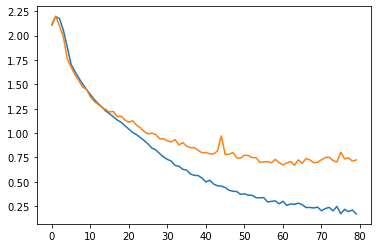

In [29]:
plt.plot(trainer.loss_history[0])
plt.plot(trainer.loss_history[1])

Overfitting seems to occur ~60 epochs

In [30]:
report = sklearn.metrics.classification_report(dic["y_true"], dic["y_pred"], target_names=ligands, output_dict=True)
rep = pd.DataFrame(report).transpose()
rep

,precision,recall,f1-score,support
TNF,0.843707,0.776081,0.808482,786.000000
R84,0.877688,0.843669,0.860343,774.000000
PIC,0.878628,0.893960,0.886228,745.000000
P3K,0.826031,0.858099,0.841760,747.000000
FLA,0.766332,0.798429,0.782051,764.000000
CpG,0.826297,0.824308,0.825301,831.000000
FSL,0.804668,0.849546,0.826498,771.000000
LPS,0.847594,0.809706,0.828217,783.000000
UST,0.983073,1.000000,0.991464,755.000000
accuracy,0.849482,0.849482,0.849482,0.849482


In [31]:
confusion = sklearn.metrics.confusion_matrix(dic["y_true"], dic["y_pred"])
confusion = sklearn.metrics.ConfusionMatrixDisplay(confusion)

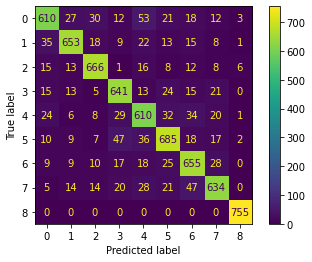

In [32]:
confusion.plot()